In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from copy import deepcopy

np.set_printoptions(precision=3, suppress=True)

column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv("./auto-mpg.data", names=column_names,
                            na_values='?', comment='\t',
                            sep=' ', skipinitialspace=True)
dataset = raw_dataset.copy()
# Turn last 0/1/2 categorical column in 3 binary columns:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
# dataset.tail()

In [2]:
# Split dataset into training and testing
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()
train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')


In [3]:
# See dataset "clouds"
# sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')


1. DNN:

In [4]:
def build_and_compile_model(norm):
    model = tf.keras.Sequential([
        norm,
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(
        loss='mean_absolute_error',
        optimizer=tf.keras.optimizers.Adam(0.001)
    )
    return model
# Plot history


def polynom(inputs: np.ndarray, degree=1):
    assert degree > 0
    if degree == 1:
        return inputs

    transposed = inputs.T
    base = len(transposed)

    pols = []
    newgen = []
    for i in range(base):
        newgen.append([i])
    pols.extend(newgen)

    for deg in range(1, degree):
        lastgen = newgen
        newgen = []
        for p in lastgen:
            for i in range(p[-1], base):
                pnext = [*p, i]
                pnext.sort()
                newgen.append(pnext)
        pols.extend(newgen)

    new_inputs = []
    for p in pols:
        new_inputs.append(deepcopy(transposed[p[0]]))
        for i in p[1:]:
            new_inputs[-1] *= transposed[i]
    return np.array(new_inputs).T

def plot_loss(history: tf.keras.callbacks.History):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)


In [5]:
x1 = train_features.to_numpy()
y = train_labels.to_numpy()
x1_test = test_features.to_numpy()
y_test = test_labels.to_numpy()

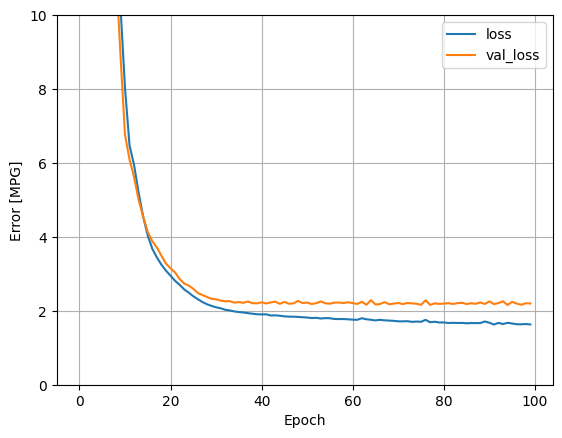

In [6]:
normalizer1 = tf.keras.layers.Normalization(axis=-1)
normalizer1.adapt(x1)
dnn_model_1 = build_and_compile_model(normalizer1)
history1 = dnn_model_1.fit(
    x1,
    y,
    validation_split=0.2,
    verbose=0, epochs=100)
plot_loss(history1)

test_results = {}
test_results['dnn_model_1'] = dnn_model_1.evaluate(x1, y, verbose=0)


In [7]:
x2 = polynom(x1,2)
x2_test = polynom(x1_test, 2)


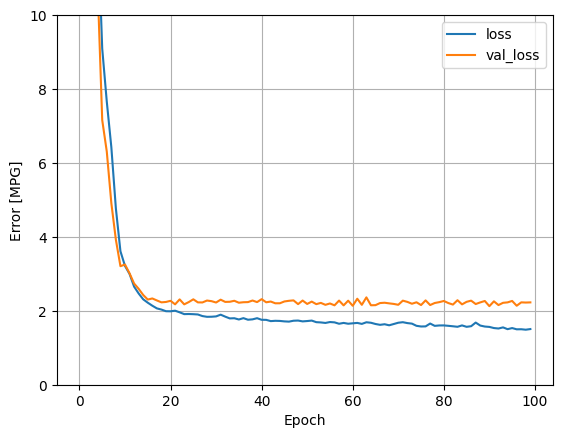

In [8]:
normalizer2 = tf.keras.layers.Normalization(axis=-1)
normalizer2.adapt(x2)
dnn_model_2 = build_and_compile_model(normalizer2)
history2 = dnn_model_2.fit(
    x2,
    y,
    validation_split=0.2,
    verbose=0, epochs=100)
plot_loss(history2)

test_results['dnn_model_2'] = dnn_model_2.evaluate(x2, y, verbose=0)


In [9]:
x3 = polynom(x1, 3)
x3_test = polynom(x1_test, 3)


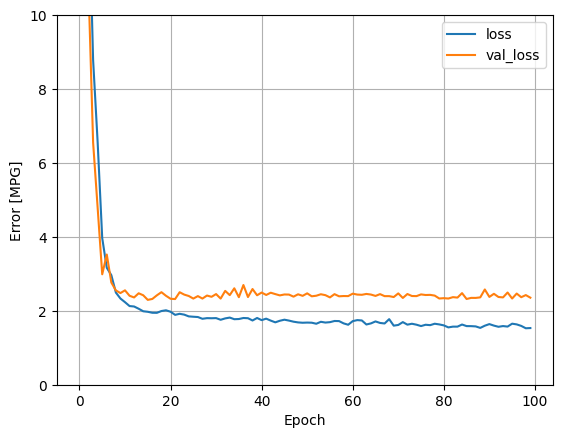

In [10]:
normalizer3 = tf.keras.layers.Normalization(axis=-1)
normalizer3.adapt(x3)
dnn_model_3 = build_and_compile_model(normalizer3)
history3 = dnn_model_3.fit(
    x3,
    y,
    validation_split=0.2,
    verbose=0, epochs=100)
plot_loss(history3)

test_results['dnn_model_3'] = dnn_model_3.evaluate(x3, y, verbose=0)


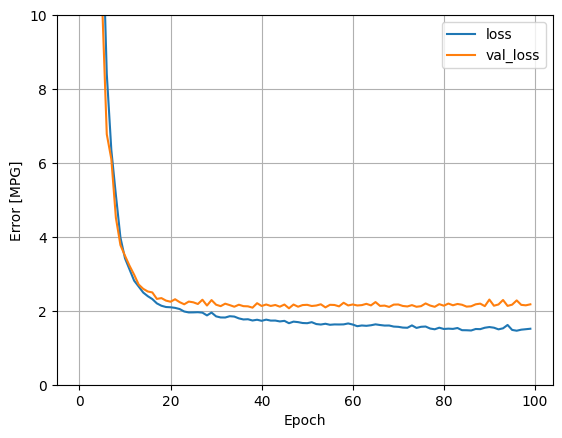

In [11]:
def build_and_compile_model_2(norm):
    model = tf.keras.Sequential([
        norm,
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(
        loss='mean_absolute_error',
        optimizer=tf.keras.optimizers.Adam(0.001)
    )
    return model
dnn_model_4 = build_and_compile_model_2(normalizer1)
history4 = dnn_model_4.fit(
    x1,
    y,
    validation_split=0.2,
    verbose=0, epochs=100)
plot_loss(history4)

test_results['dnn_model_4'] = dnn_model_4.evaluate(x1, y, verbose=0)


In [12]:
x4 = polynom(x1, 4)
x4_test = polynom(x1_test, 4)


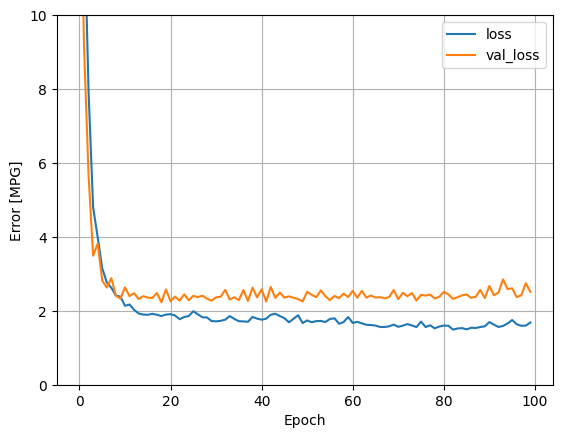

In [13]:
normalizer5 = tf.keras.layers.Normalization(axis=-1)
normalizer5.adapt(x4)
dnn_model_5 = build_and_compile_model(normalizer5)
history5 = dnn_model_5.fit(
    x4,
    y,
    validation_split=0.2,
    verbose=0, epochs=100)
plot_loss(history5)

test_results['dnn_model_5'] = dnn_model_5.evaluate(x4, y, verbose=0)


In [14]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T


,Mean absolute error [MPG]
dnn_model_1,1.727867
dnn_model_2,1.635447
dnn_model_3,1.661845
dnn_model_4,1.567291
dnn_model_5,1.872188


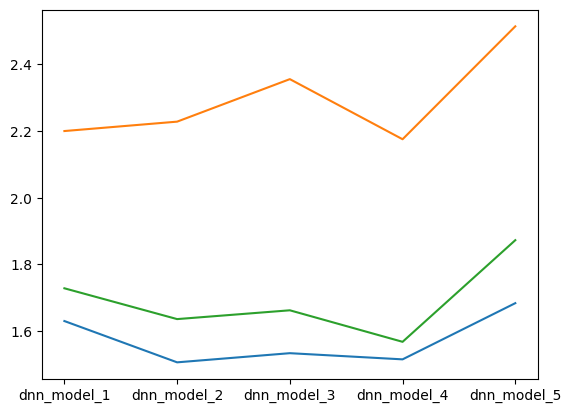

In [15]:
x5 = polynom(x1, 3)
x5_test = polynom(x1_test, 3)
lastcv = []
history1.history['loss']
for hist in [history1,history2,history3,history4, history5]:
    lastcv.append([hist.history['loss'][-1], hist.history['val_loss'][-1]])
lastcv = np.array(lastcv)
plt.plot(lastcv[:,0])
plt.plot(lastcv[:,1])
plt.plot(pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T)


In [16]:
#####################################################################